Convolutional neural network
---
We are going to build a neural network connecting multiple neurons in a structure known as Convolutional Neural Network (CNN).

A CNN is a feed-forward neural network tipically composed of Convolutional, MaxPooling and Dense layers.
Relu, Dropout, and batchnorm layers are usually present to improve the final accuracy of the model.

In this example, we will use keras with Tensorflow as backend.


In [42]:
# Import the required packages
import numpy as np
np.random.seed(129238)  # Reproducibilty
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

#Import keras mnist dataset, backend model, layers and optimizer
import keras
from keras.datasets import mnist
from keras import backend as TF
from keras.models import Sequential, save_model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD 
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard,ModelCheckpoint


Prepare Input data
----


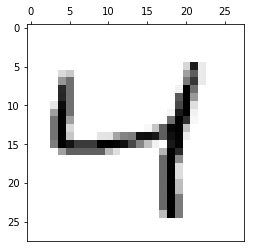

In [23]:
#Download the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test_orig = x_test
#In case we want to display images from the dataset
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
imgplot = ax.imshow(x_train[2], cmap=mpl.cm.Greys)
imgplot.set_interpolation('nearest')
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.show()

Define Model parameters
----


In [27]:
#Neural Network parameters
batch_size = 64
num_classes = 10
num_epochs = 10
# number of convolutional filters to use
num_filters = 32  
# size of pooling area for max pooling
num_pool = 2
# convolution kernel size
num_conv = 3

#Define Tensorboard callback in keras to generate a visualization of the model output
tensorboard = keras.callbacks.TensorBoard(
    log_dir='logs/', 
    histogram_freq=1
)

#Define the optimizer (keras SGD)
optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)


Reshape input data
---

In [28]:
img_rows, img_cols = 28, 28

#When dealing with images & convolutions in keras, we need to properly handle image_data_format 
if TF.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Reshape input data
x_train = x_train.reshape((x_train.shape[0],) + shape_ord)
x_test = x_test.reshape((x_test.shape[0],) + shape_ord)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Test data
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


60000 train samples
10000 test samples


Create the model
---


In [35]:
#ConvNet model definition
model = Sequential()

model.add(Conv2D(num_filters, (num_conv, num_conv),padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(Conv2D(num_filters, (num_conv, num_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(num_pool, num_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                   beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                   moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                   beta_constraint=None, gamma_constraint=None)
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Layer shape and weight insights
---

The input shape of the first convolutional layer must be specified by the user. The rest of the layer shapes are automatically defined internally by keras. 
Note that Dense layers need the output shape, as it defines the activation function. 

In a simillar way, Keras lets you inspect weights by returning a list with two elements, the weight tensor and the bias vector. As MaxPooling layers don't have learnable parameters, there are no weights to be extracted.

In [135]:
print("Layer Shapes:")
for i, layer in enumerate(model.layers):
     print ("Layer", i, "\t", layer.input_shape, "\t", layer.output_shape)
    
print("\nLayer Weights:")
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
         print("Layer", i, "\t", layer.get_weights()[0].shape, "     \t", layer.get_weights()[1].shape)

Layer Shapes:
Layer 0 	 (None, 28, 28, 1) 	 (None, 26, 26, 32)
Layer 1 	 (None, 26, 26, 32) 	 (None, 26, 26, 32)
Layer 2 	 (None, 26, 26, 32) 	 (None, 24, 24, 32)
Layer 3 	 (None, 24, 24, 32) 	 (None, 24, 24, 32)
Layer 4 	 (None, 24, 24, 32) 	 (None, 12, 12, 32)
Layer 5 	 (None, 12, 12, 32) 	 (None, 12, 12, 32)
Layer 6 	 (None, 12, 12, 32) 	 (None, 4608)
Layer 7 	 (None, 4608) 	 (None, 128)
Layer 8 	 (None, 128) 	 (None, 128)
Layer 9 	 (None, 128) 	 (None, 128)
Layer 10 	 (None, 128) 	 (None, 10)
Layer 11 	 (None, 10) 	 (None, 10)

Layer Weights:
Layer 0 	 (3, 3, 1, 32)      	 (32,)
Layer 2 	 (3, 3, 32, 32)      	 (32,)
Layer 7 	 (4608, 128)      	 (128,)
Layer 10 	 (128, 10)      	 (10,)


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
__________

Train Model
---
Including saving model during training phase
Plot loss and accuracy per epoch

In [48]:
save_model(model, './logs/model_mlp')
checkpoint = ModelCheckpoint(filepath='./logs/weights.epoch.{epoch:02d}-val_loss.{val_loss:.2f}.hdf5', verbose=0)
history = model.fit(x_train, y_train, batch_size=batch_size, 
                 epochs=num_epochs, verbose=1, 
                 callbacks=[checkpoint,TensorBoard(log_dir='./logs/09_tensorboard', histogram_freq=0)],
                 validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s - loss: 0.0330 - acc: 0.9895 - val_loss: 0.0311 - val_acc: 0.9905
Epoch 2/10
60000/60000 [==============================] - 3s - loss: 0.0313 - acc: 0.9896 - val_loss: 0.0306 - val_acc: 0.9910
Epoch 3/10
60000/60000 [==============================] - 3s - loss: 0.0316 - acc: 0.9894 - val_loss: 0.0315 - val_acc: 0.9906
Epoch 4/10
60000/60000 [==============================] - 3s - loss: 0.0314 - acc: 0.9900 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 5/10
60000/60000 [==============================] - 3s - loss: 0.0281 - acc: 0.9906 - val_loss: 0.0280 - val_acc: 0.9920
Epoch 6/10
60000/60000 [==============================] - 3s - loss: 0.0281 - acc: 0.9910 - val_loss: 0.0249 - val_acc: 0.9920
Epoch 7/10
60000/60000 [==============================] - 3s - loss: 0.0273 - acc: 0.9908 - val_loss: 0.0276 - val_acc: 0.9914
Epoch 8/10
60000/60000 [==============================] - 3s 

In [50]:
# Restore trained model
loaded_model = load_model('./logs/model_mlp')
loaded_model.load_weights('./logs/weights.epoch.09-val_loss.0.03.hdf5')
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
__________

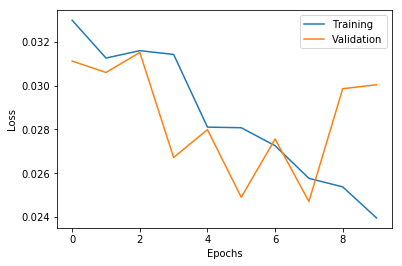

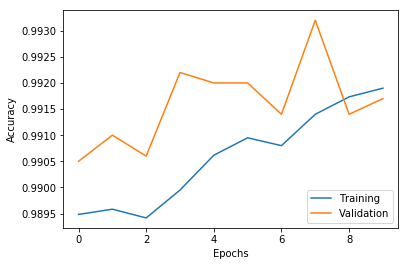

In [51]:
#Using matplotlib instead of TB for loss and accuracy plotting
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

In [52]:
# Evaluate the model    
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.0300406433482
Test Accuracy: 0.9917


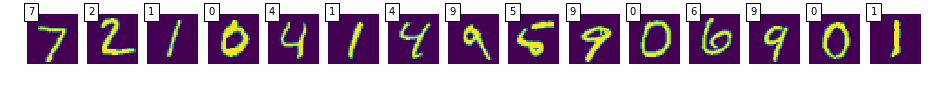

In [53]:
slice = 15
predicted = model.predict(x_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(x_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')